# **Scraping AloDokter App Reviews**

**Nama**  : Anak Agung Istri Istadewanti

**NRP**     : 5026211143

**Kelas** : PBA (A)

# SET UP

In [1]:
# Install libraries
!pip install google_play_scraper
!pip install textblob
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.7 MB/s eta 0:00:00


In [2]:
# Import Libraries
# Standard libraries
import os
import time
import datetime
import re
from pathlib import Path
from PIL import Image

# Data handling and visualization libraries
import pandas as pd
import numpy as np
import regex as re
import nltk
import string
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates

# Machine learning and NLP libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from google_play_scraper import app, Sort, reviews, reviews_all
from copy import deepcopy
from IPython.display import clear_output
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Matplotlib Configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15, 10)

print("Libraries imported successfully.")

Libraries imported successfully.


<ipython-input-2-b8a24b1084b5>:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Scraping App Reviews


* Nama aplikasi yang akan di-*scraping* *review*-nya pada Google Play adalah **Alodokter —Chat Bersama Dokter**

*   Link App Android dari AloDokter pada Google Play:
https://play.google.com/store/apps/details?id=com.alodokter.android&hl=id
*   ID aplikasi AloDokter adalah `id=com.alodokter.android`
* Pada tanggal 07 September, jumlah review aplikasi pada Google Play adalah **458 ribu**.






In [3]:
# Mengambil review aplikasi Alodokter dari Google Play Store

# Fungsi untuk mengambil jumlah review berdasarkan yang diinginkan
def scrap_alodokter_reviews(
    app_id='com.alodokter.android',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    total_reviews=25000,
    filter_score_with=None,
    filter_device_with=None
) -> list:
    # Mengambil batch pertama dari 100 review
    all_result, review_token = reviews(
        app_id,
        lang=lang,
        country=country,
        sort=sort,
        count=100,
        filter_score_with=filter_score_with,
        filter_device_with=filter_device_with,
        continuation_token=None  # Batch pertama, tanpa token kelanjutan
    )

    # Menghitung berapa kali kita perlu mengulang pengambilan data (25.000 / 100 = 250 kali)
    multiples = int(total_reviews / 100 - 1)
    print(f"Total reviews: {len(all_result)}/{total_reviews}")

    # Proses pengambilan batch selanjutnya hingga mencapai total_reviews yang diinginkan
    for i in range(multiples):
        result = []
        iterate_status = True
        token = deepcopy(review_token)  # Menyimpan token untuk batch berikutnya
        while iterate_status:
            result, review_token = reviews(app_id, continuation_token=token)
            if review_token.token:
                iterate_status = False
        for review in result:
            all_result.append(review)
        clear_output(wait=True)  # Membersihkan output untuk memantau progress
        print(f"Total reviews: {len(all_result)}/{total_reviews}")

    return all_result

# Mengambil 25.000 review
alodokter_reviews = scrap_alodokter_reviews(total_reviews=25000)

Total reviews: 25000/25000


In [4]:
# Simpan review ke dalam DataFrame
df_alodokter = pd.DataFrame(np.array(alodokter_reviews), columns=['content'])
df_alodokter = df_alodokter.join(pd.DataFrame(df_alodokter.pop('content').tolist()))
df_alodokter.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c820b46e-0687-40b5-8239-3bf8dbb334ea,Makka Raya Pambodalle,https://play-lh.googleusercontent.com/a-/ALV-U...,bagus cepat,5,0,6.8.0,2024-09-08 02:57:22,None,NaT,6.8.0
1,3dfbf549-df69-4e7e-9464-aa0bdc98d2ab,Odikz odikz,https://play-lh.googleusercontent.com/a-/ALV-U...,Dokternya ramah dan cepat dalm menjawab konsul...,2,0,6.8.0,2024-09-07 18:17:00,None,NaT,6.8.0
2,48f0e624-8248-42f4-ba8d-e5811eb8e533,Janna Tunnisa,https://play-lh.googleusercontent.com/a-/ALV-U...,penjelasan sangat detail dan dokternya ramah G...,5,0,6.8.0,2024-09-07 14:29:55,None,NaT,6.8.0
3,b685b579-4b09-419c-bb23-922dacae142f,Eka Uhuy,https://play-lh.googleusercontent.com/a/ACg8oc...,ingin tahu tentang kedokteran,5,0,6.8.0,2024-09-07 11:56:23,None,NaT,6.8.0
4,a0004ab9-d3ad-45b3-bf6d-648db91df4dd,Hairina Mandea,https://play-lh.googleusercontent.com/a-/ALV-U...,sangat rinci,4,0,6.8.0,2024-09-07 02:58:06,None,NaT,6.8.0


In [5]:
# Menampilkan jumlah baris dan kolom DataFrame
print(f"Jumlah data yang telah di-scraping: {df_alodokter.shape[0]}")

Jumlah data yang telah di-scraping: 25000


In [6]:
# Simpan DataFrame ke dalam file CSV di direktori saat ini
file_path = 'df_alodokter_reviews.csv'

# Simpan DataFrame ke dalam file CSV
df_alodokter.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_reviews.csv


# Preprocessing Data

Sebelum menganalisis lebih lanjut, kita harus memahami tipe dan informasi lainnya terkait data yang telah kita miliki.

Dengan menggunakan fungsi `info`, dapat dilihat bahwa kolom "reviewCreatedVersion", "replyContent", "repliedAt", dan "appVersion" memiliki nilai null.

In [7]:
# Informasi terkait data
df_alodokter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              25000 non-null  object        
 1   userName              25000 non-null  object        
 2   userImage             25000 non-null  object        
 3   content               25000 non-null  object        
 4   score                 25000 non-null  int64         
 5   thumbsUpCount         25000 non-null  int64         
 6   reviewCreatedVersion  20851 non-null  object        
 7   at                    25000 non-null  datetime64[ns]
 8   replyContent          12878 non-null  object        
 9   repliedAt             12878 non-null  datetime64[ns]
 10  appVersion            20851 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 2.1+ MB


Selanjutnya kita ingin melihat semua nilai unik dalam kolom 'reviewCreatedVersion' untuk mengetahui versi apa saja yang tersedia pada review app AloDokter yang telah kita ambil.

In [8]:
unique_versions = df_alodokter.reviewCreatedVersion.unique()
print("Versi Aplikasi yang Unik dalam Review:")
print(unique_versions)

num_unique_versions = df_alodokter.reviewCreatedVersion.nunique()
print(f"\nJumlah versi aplikasi dalam review yang diambil adalah: {num_unique_versions}")

Versi Aplikasi yang Unik dalam Review:
['6.8.0' None '3.7.0' '6.7.0' '1.8.0' '6.6.0' '6.5.0' '6.4.1' '2.2.3'
 '6.3.0' '1.9.0' '6.0.0' '2.1.1' '3.5.0' '3.1.1' '2.9.1' '5.3.0' '3.0.0'
 '5.8.0' '3.3.0' '4.4.0' '6.2.0' '6.1.0' '2.8.0' '6.4.0' '5.6.0' '2.4.1'
 '2.5.3' '2.5.4' '3.9.1' '5.7.0' '2.0.2' '5.2.0' '5.9.0' '2.5.1' '5.4.0'
 '5.5.0' '3.2.0' '1.5.0' '2.7.0' '5.1.0' '3.6.0' '1.2.1' '2.2.4' '4.9.0'
 '2.5.2' '1.4.0' '2.3.2' '4.8.0' '5.0.0' '1.6.0' '3.4.1' '4.5.1' '4.7.0'
 '4.6.0' '4.7.1' '4.0.0' '3.8.0' '2.4.2' '4.2.1' '4.3.0' '4.2.0' '2.3.5'
 '4.1.0' '2.4.0' '2.3.3' '2.2.0' '4.5.0' '1.4.1' '3.8.1' '4.2.2' '1.9.1'
 '3.6.1' '2.2.1' '1.3.1' '3.6.2' '3.1.0' '2.1.0' '3.9.0' '1.8.2' '1.4.2'
 '2.5.0' '1.3.0' '2.3.4' '3.4.0' '1.7.0' '1.6.1' '2.0.1' '1.1.2']

Jumlah versi aplikasi dalam review yang diambil adalah: 88


## Menghapus Emoji

Dapat dilihat pada DataFrame di atas bahwa kolom "content" ada yang berisi emoji saja. Oleh karena itu, kita akan menghapus emoji yang terdapat pada kolom "content"

In [9]:
# Fungsi untuk menghapus emoji dan karakter khusus dari teks
# Source: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emojis(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Menghapus emoji dan simbol dari kolom 'content'
df_alodokter['content'] = df_alodokter['content'].apply(remove_emojis)

In [10]:
df_alodokter

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c820b46e-0687-40b5-8239-3bf8dbb334ea,Makka Raya Pambodalle,https://play-lh.googleusercontent.com/a-/ALV-U...,bagus cepat,5,0,6.8.0,2024-09-08 02:57:22,None,NaT,6.8.0
1,3dfbf549-df69-4e7e-9464-aa0bdc98d2ab,Odikz odikz,https://play-lh.googleusercontent.com/a-/ALV-U...,Dokternya ramah dan cepat dalm menjawab konsul...,2,0,6.8.0,2024-09-07 18:17:00,None,NaT,6.8.0
2,48f0e624-8248-42f4-ba8d-e5811eb8e533,Janna Tunnisa,https://play-lh.googleusercontent.com/a-/ALV-U...,penjelasan sangat detail dan dokternya ramah G...,5,0,6.8.0,2024-09-07 14:29:55,None,NaT,6.8.0
3,b685b579-4b09-419c-bb23-922dacae142f,Eka Uhuy,https://play-lh.googleusercontent.com/a/ACg8oc...,ingin tahu tentang kedokteran,5,0,6.8.0,2024-09-07 11:56:23,None,NaT,6.8.0
4,a0004ab9-d3ad-45b3-bf6d-648db91df4dd,Hairina Mandea,https://play-lh.googleusercontent.com/a-/ALV-U...,sangat rinci,4,0,6.8.0,2024-09-07 02:58:06,None,NaT,6.8.0
...,...,...,...,...,...,...,...,...,...,...,...
24995,d2b0da9f-4a91-40cc-baac-55675a4da2aa,Mutiara R,https://play-lh.googleusercontent.com/a-/ALV-U...,Awalnya bagus karena dokter merespon obat apa ...,1,2,3.2.0,2021-06-29 23:47:25,"Alo, Mutiandhana R! Terima kasih telah menggun...",2021-06-29 07:37:14,3.2.0
24996,ffd74e92-e5ab-4bb5-be00-3ab45d2d9239,Abu Hudzaifah,https://play-lh.googleusercontent.com/a/ACg8oc...,Sangat membantu,5,11,3.2.0,2021-06-29 23:39:43,"Alo, Abu Hudzaifah! Terima kasih telah menggun...",2021-06-30 00:06:27,3.2.0
24997,1fbca6cd-730e-4f26-b527-ad9378dfb585,Endang nasrudin jaelani,https://play-lh.googleusercontent.com/a-/ALV-U...,Mantul,5,10,3.2.0,2021-06-29 19:59:03,None,NaT,3.2.0
24998,306bff9c-e390-4b66-9bad-c41a44f4a9ea,Elvia Vincentia,https://play-lh.googleusercontent.com/a-/ALV-U...,Penjelasannya sangat jelas dg bahasa yg mudah ...,5,13,3.2.0,2021-06-29 19:54:31,"Alo, Elvia Vincentia! Terima kasih telah mengg...",2021-06-30 00:05:11,3.2.0


## Menghapus Review yang Kosong

Menghapus emoji dan karakter spesial memungkinkan beberapa review menjadi kosong, sehingga kita harus mengecek dan menghapusnya bila ada.

In [11]:
# Menghapus review yang bernilai kosong
df_alodokter = df_alodokter[df_alodokter['content'] != '']

In [12]:
# Memeriksa apakah masih ada review kosong pada kolom 'content' atau tidak
df_alodokter[df_alodokter['content'] == '']

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion


In [13]:
# Jumlah data setelah melakukan preprocessing
df_alodokter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24746 entries, 0 to 24998
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              24746 non-null  object        
 1   userName              24746 non-null  object        
 2   userImage             24746 non-null  object        
 3   content               24746 non-null  object        
 4   score                 24746 non-null  int64         
 5   thumbsUpCount         24746 non-null  int64         
 6   reviewCreatedVersion  20637 non-null  object        
 7   at                    24746 non-null  datetime64[ns]
 8   replyContent          12855 non-null  object        
 9   repliedAt             12855 non-null  datetime64[ns]
 10  appVersion            20637 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 2.3+ MB


## Lowercasing Reviews

Membuat seluruh teks pada kolom 'content' menjadi huruf kecil menjadi hal yang penting agar teks menjadi konsisten dan homogen. Hal ini juga bertujuan untuk meningkatkan akurasi dari setiap teks.

In [14]:
# Mengubah tipe data kolom content menjadi string
df_alodokter.loc[:, 'content'] = df_alodokter['content'].astype(str)

In [15]:
# Mengubah semua teks di kolom 'content' menjadi huruf kecil
df_alodokter.loc[:, 'content'] = df_alodokter['content'].apply(lambda x: x.lower())

In [16]:
df_alodokter

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c820b46e-0687-40b5-8239-3bf8dbb334ea,Makka Raya Pambodalle,https://play-lh.googleusercontent.com/a-/ALV-U...,bagus cepat,5,0,6.8.0,2024-09-08 02:57:22,None,NaT,6.8.0
1,3dfbf549-df69-4e7e-9464-aa0bdc98d2ab,Odikz odikz,https://play-lh.googleusercontent.com/a-/ALV-U...,dokternya ramah dan cepat dalm menjawab konsul...,2,0,6.8.0,2024-09-07 18:17:00,None,NaT,6.8.0
2,48f0e624-8248-42f4-ba8d-e5811eb8e533,Janna Tunnisa,https://play-lh.googleusercontent.com/a-/ALV-U...,penjelasan sangat detail dan dokternya ramah g...,5,0,6.8.0,2024-09-07 14:29:55,None,NaT,6.8.0
3,b685b579-4b09-419c-bb23-922dacae142f,Eka Uhuy,https://play-lh.googleusercontent.com/a/ACg8oc...,ingin tahu tentang kedokteran,5,0,6.8.0,2024-09-07 11:56:23,None,NaT,6.8.0
4,a0004ab9-d3ad-45b3-bf6d-648db91df4dd,Hairina Mandea,https://play-lh.googleusercontent.com/a-/ALV-U...,sangat rinci,4,0,6.8.0,2024-09-07 02:58:06,None,NaT,6.8.0
...,...,...,...,...,...,...,...,...,...,...,...
24994,d8f572ef-9b2a-48cc-93db-f639203978c5,dian smamuhkdr,https://play-lh.googleusercontent.com/a-/ALV-U...,mantap,5,10,3.2.0,2021-06-30 00:30:09,None,NaT,3.2.0
24995,d2b0da9f-4a91-40cc-baac-55675a4da2aa,Mutiara R,https://play-lh.googleusercontent.com/a-/ALV-U...,awalnya bagus karena dokter merespon obat apa ...,1,2,3.2.0,2021-06-29 23:47:25,"Alo, Mutiandhana R! Terima kasih telah menggun...",2021-06-29 07:37:14,3.2.0
24996,ffd74e92-e5ab-4bb5-be00-3ab45d2d9239,Abu Hudzaifah,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat membantu,5,11,3.2.0,2021-06-29 23:39:43,"Alo, Abu Hudzaifah! Terima kasih telah menggun...",2021-06-30 00:06:27,3.2.0
24997,1fbca6cd-730e-4f26-b527-ad9378dfb585,Endang nasrudin jaelani,https://play-lh.googleusercontent.com/a-/ALV-U...,mantul,5,10,3.2.0,2021-06-29 19:59:03,None,NaT,3.2.0


In [17]:
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport


#from nltk import word_tokenize, sent_tokenize
#from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
#from wordcloud import WordCloud, STOPWORDS
#from textblob import TextBlob


## Seleksi Kolom yang Digunakan

Dari 11 kolom yang ada, tidak semua kolom akan digunakan untuk analisis sentimen. Pada tahap ini kolom akan dipilih berdasarkan yang paling relevan saja.

In [18]:
df_alodokter.loc[0:3,["content", "score", "thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,bagus cepat,5,0,6.8.0,2024-09-08 02:57:22,None,NaT
1,"dokternya ramah dan cepat dalm menjawab konsultasi pasien, namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampai"".sya berhar...",2,0,6.8.0,2024-09-07 18:17:00,None,NaT
2,penjelasan sangat detail dan dokternya ramah good joob,5,0,6.8.0,2024-09-07 14:29:55,None,NaT
3,ingin tahu tentang kedokteran,5,0,6.8.0,2024-09-07 11:56:23,None,NaT


# Sentiment Analysis

## Sentiment Polarity & Subjectivity

Pada tahap ini, kita akan menghitung nilai *sentiment polarity* dan *sentiment subjective* pada kolom 'content' menggunakan `TextBlob`.
Lebih lengkap dapat dilihat pada: https://textblob.readthedocs.io/en/dev/quickstart.html

In [19]:
# Menghitung polaritas dan subjektivitas sentimen
df_alodokter.loc[:, 'sentiment_polarity'] = df_alodokter['content'].apply(lambda x: TextBlob(x).polarity)
df_alodokter.loc[:, 'sentiment_subjective'] = df_alodokter['content'].apply(lambda x: TextBlob(x).subjectivity)

<ipython-input-19-8ee93b9acf88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter.loc[:, 'sentiment_polarity'] = df_alodokter['content'].apply(lambda x: TextBlob(x).polarity)
<ipython-input-19-8ee93b9acf88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter.loc[:, 'sentiment_subjective'] = df_alodokter['content'].apply(lambda x: TextBlob(x).subjectivity)


In [20]:
df_alodokter.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
0,bagus cepat,5,0.0,0.0
1,"dokternya ramah dan cepat dalm menjawab konsultasi pasien, namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampai"".sya berhar...",2,0.0,0.0
2,penjelasan sangat detail dan dokternya ramah good joob,5,0.7,0.6
3,ingin tahu tentang kedokteran,5,0.0,0.0
4,sangat rinci,4,0.0,0.0
...,...,...,...,...
24994,mantap,5,0.0,0.0
24995,"awalnya bagus karena dokter merespon obat apa yg harus ditebus, ketika sudah ditebus di aloshop, pengiriman obatnya ga datang datang padahal ambil pengiriman yg 3 jam sampai, pelayanan buruk !!! j...",1,0.0,0.0
24996,sangat membantu,5,0.0,0.0
24997,mantul,5,0.0,0.0


In [21]:
# Mengecek jumlah data setiap rating (kolom "score")
df_alodokter['score'].value_counts()

,count
score,
5,17901
1,3911
4,1733
3,726
2,475


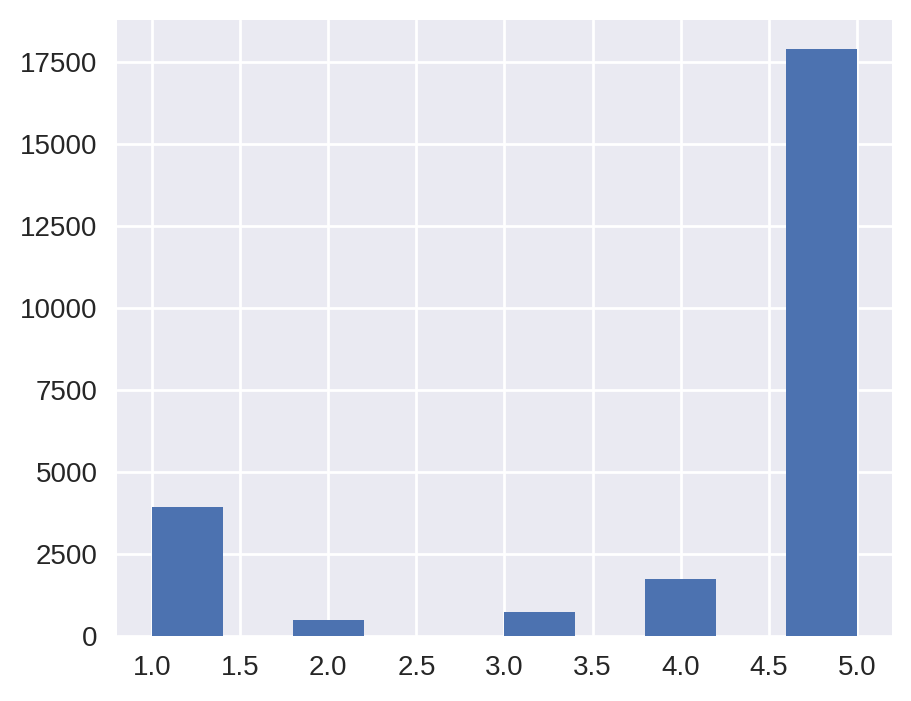

In [22]:
# Menampilkan review score ke dalam bar chart
plt.figure(figsize=[5,4])
plt.hist(df_alodokter['score'])
plt.show()

## Sentiment Rating

Setelah mengetahui jumlah rating dari setiap pengguna pada review aplikasi AloDokter di Google Play, kita dapat mengategorikan review ke dalam sentiment rating dimana **Positive** (rating 4/5), **Netral** (rating 3), **Negative** (rating 1/2).

In [23]:
# Menambah kolom sentiment_rating
df_alodokter.loc[:, 'sentiment_rating'] = df_alodokter['score'].apply(lambda x: 'Positive' if x > 3 else ('Neutral' if x == 3 else 'Negative'))

<ipython-input-23-430d9250d78b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter.loc[:, 'sentiment_rating'] = df_alodokter['score'].apply(lambda x: 'Positive' if x > 3 else ('Neutral' if x == 3 else 'Negative'))


In [24]:
df_alodokter.loc[:,["content", "score", "sentiment_polarity", "sentiment_subjective", "sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,bagus cepat,5,0.0,0.0,Positive
1,"dokternya ramah dan cepat dalm menjawab konsultasi pasien, namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampai"".sya berhar...",2,0.0,0.0,Negative
2,penjelasan sangat detail dan dokternya ramah good joob,5,0.7,0.6,Positive
3,ingin tahu tentang kedokteran,5,0.0,0.0,Positive
4,sangat rinci,4,0.0,0.0,Positive
...,...,...,...,...,...
24994,mantap,5,0.0,0.0,Positive
24995,"awalnya bagus karena dokter merespon obat apa yg harus ditebus, ketika sudah ditebus di aloshop, pengiriman obatnya ga datang datang padahal ambil pengiriman yg 3 jam sampai, pelayanan buruk !!! j...",1,0.0,0.0,Negative
24996,sangat membantu,5,0.0,0.0,Positive
24997,mantul,5,0.0,0.0,Positive


Selanjutnya kita akan melakukan visualisasi untuk membandingkan sentiment rating dengan nilai polarity dan subjective menggunakan scatter plot.

* **Sumbu x** menunjukkan `polaritas` dari review app
dengan rentang `-1 hingga 1`. Jika nilai berada pada rentang negatif, maka sentimen bernilai negatif. Jika berada pada rentang positif, maka sentimen bernilai positif. Jika nilai berada di angka 0 itu artinya netral.
* **Sumbu y** menunjukkan `subjektivitas` dari review app dengan rentang `0 hingga 1`. Nilai 0 berarti ulasan tersebut lebih objektif (berdasarkan fakta), sedangkan nilai 1 menunjukkan ulasan yang lebih subjektif (berdasarkan opini pribadi).
* **Hue (sentiment rating)**: Biru = negative, orange = positive, hijau = netral.



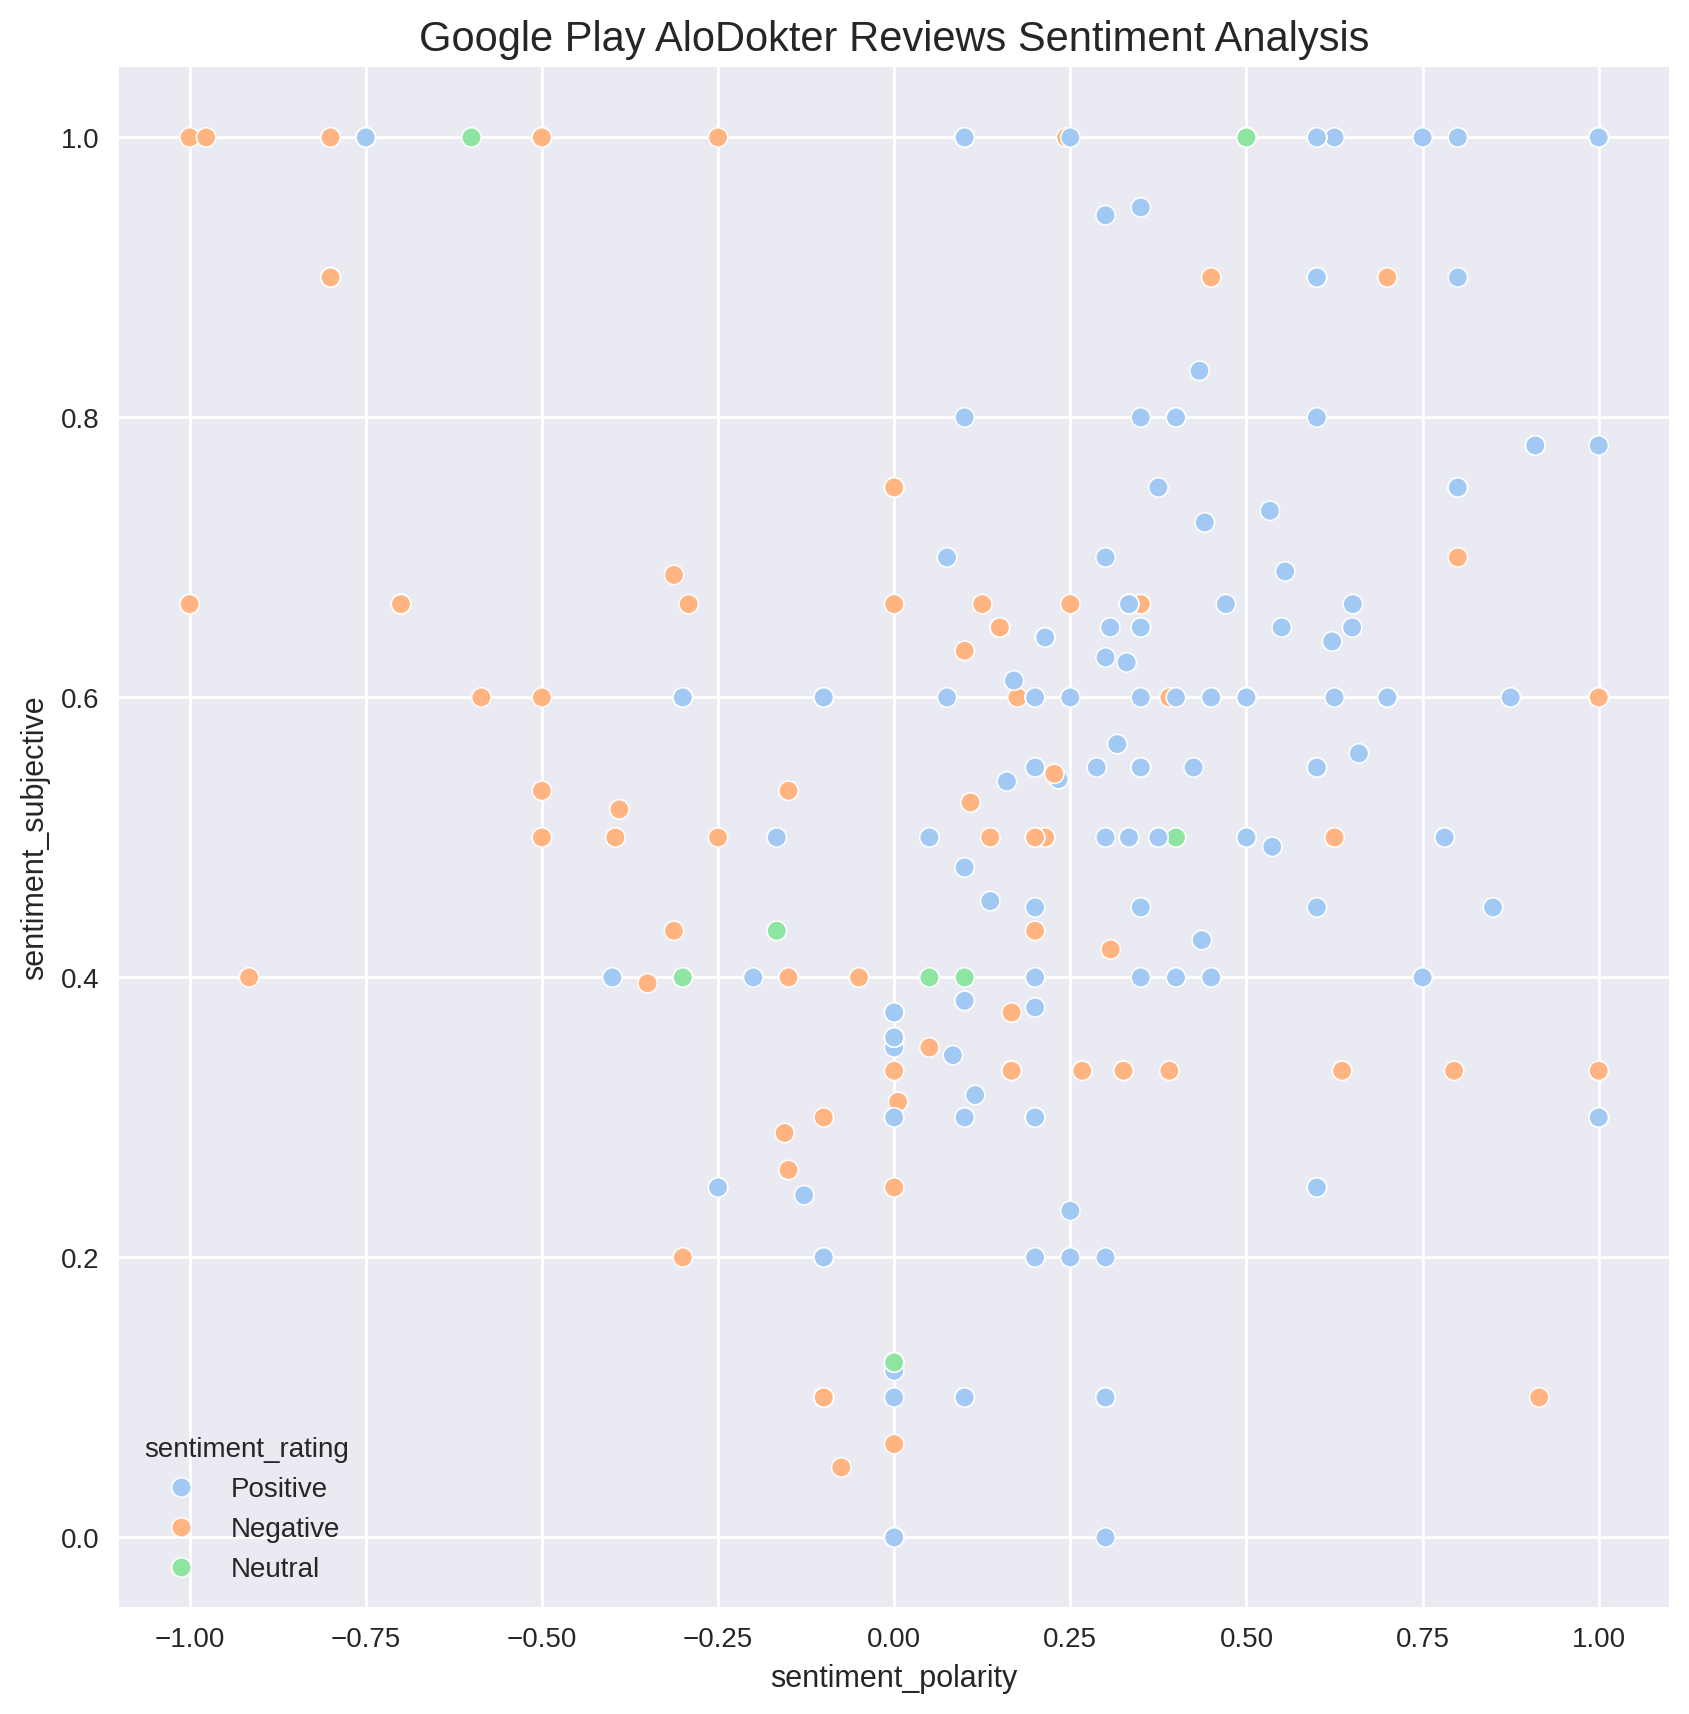

In [25]:
# Membandingkan sentiment rating dengan nilai polarity dan subjective (TextBlob)
plt.figure(figsize=(10, 10))
sns.scatterplot(df_alodokter, x='sentiment_polarity', y='sentiment_subjective',
                hue='sentiment_rating', edgecolor='white', palette="pastel")
plt.title("Google Play AloDokter Reviews Sentiment Analysis", fontsize=15)
plt.show()

**Kesimpulan dari hasil visualisasi:**

* Jumlah review yang diambil cukup banyak (24.7k), tetapi persebaran pada scatter plot terlihat hanya mencakup sedikit titik. Dapat dikatakan bahwa **TextBlob kurang mampu menganalisis review Bahasa Indonesia**, sehingga banyak review memiliki polaritas dan subjektivitas nol/tidak terdeteksi.
* Karena sebagian besar ulasan tidak terhitung (memiliki nilai 0 dan tidak ditampilkan), maka **analisis ini tidak memberikan gambaran yang akurat dari keseluruhan sentimen pengguna**. Persebaran nilai yang terlihat dalam plot hanya mencakup sebagian kecil dari dataset yang berhasil dianalisis, yang menyebabkan kesimpulan yang diambil dari scatter plot ini bisa sangat bias dan tidak mewakili populasi ulasan yang sebenarnya.

# Text Analysis (Sebelum Stopwords)

In [26]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # Untuk fungsi word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [27]:
# Menghitung jumlah kata dengan tokenisasi menggunakan NLTK
df_alodokter['wordCount'] = df_alodokter['content'].apply(lambda x: len(word_tokenize(x)))
df_alodokter['uppercaseCharCount'] = [sum(char.isupper() for char in review) for review in df_alodokter['content']]
df_alodokter['specialCharCount'] = [sum(char in string.punctuation for char in review) for review in df_alodokter['content']]

<ipython-input-27-6a1cd59cffbf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter['wordCount'] = df_alodokter['content'].apply(lambda x: len(word_tokenize(x)))
<ipython-input-27-6a1cd59cffbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter['uppercaseCharCount'] = [sum(char.isupper() for char in review) for review in df_alodokter['content']]
<ipython-input-27-6a1cd59cffbf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [28]:
df_alodokter.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,bagus cepat,5,0.0,0.0,2,0,0
1,"dokternya ramah dan cepat dalm menjawab konsultasi pasien, namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampai"".sya berhar...",2,0.0,0.0,40,0,3
2,penjelasan sangat detail dan dokternya ramah good joob,5,0.7,0.6,8,0,0
3,ingin tahu tentang kedokteran,5,0.0,0.0,4,0,0
4,sangat rinci,4,0.0,0.0,2,0,0
...,...,...,...,...,...,...,...
24994,mantap,5,0.0,0.0,1,0,0
24995,"awalnya bagus karena dokter merespon obat apa yg harus ditebus, ketika sudah ditebus di aloshop, pengiriman obatnya ga datang datang padahal ambil pengiriman yg 3 jam sampai, pelayanan buruk !!! j...",1,0.0,0.0,56,0,10
24996,sangat membantu,5,0.0,0.0,2,0,0
24997,mantul,5,0.0,0.0,1,0,0


In [29]:
# Fungsi untuk menghitung kata yang sering muncul
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

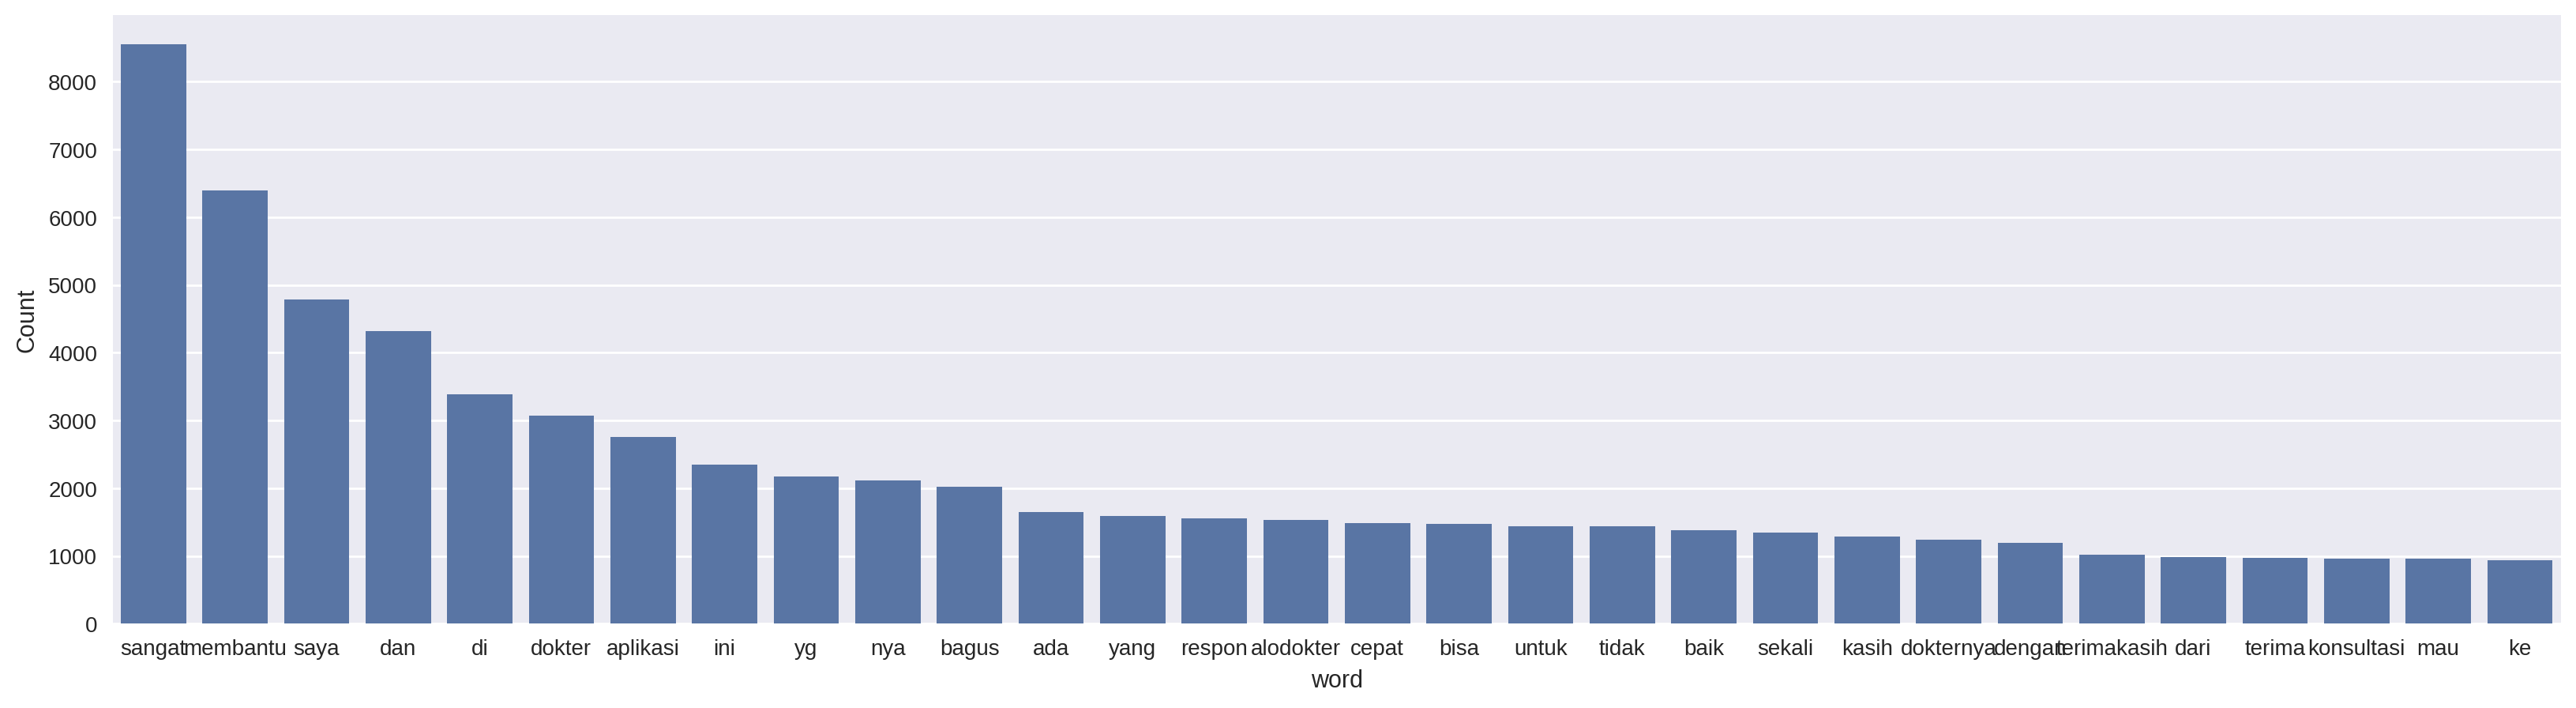

In [30]:
freq_words(df_alodokter['content'])

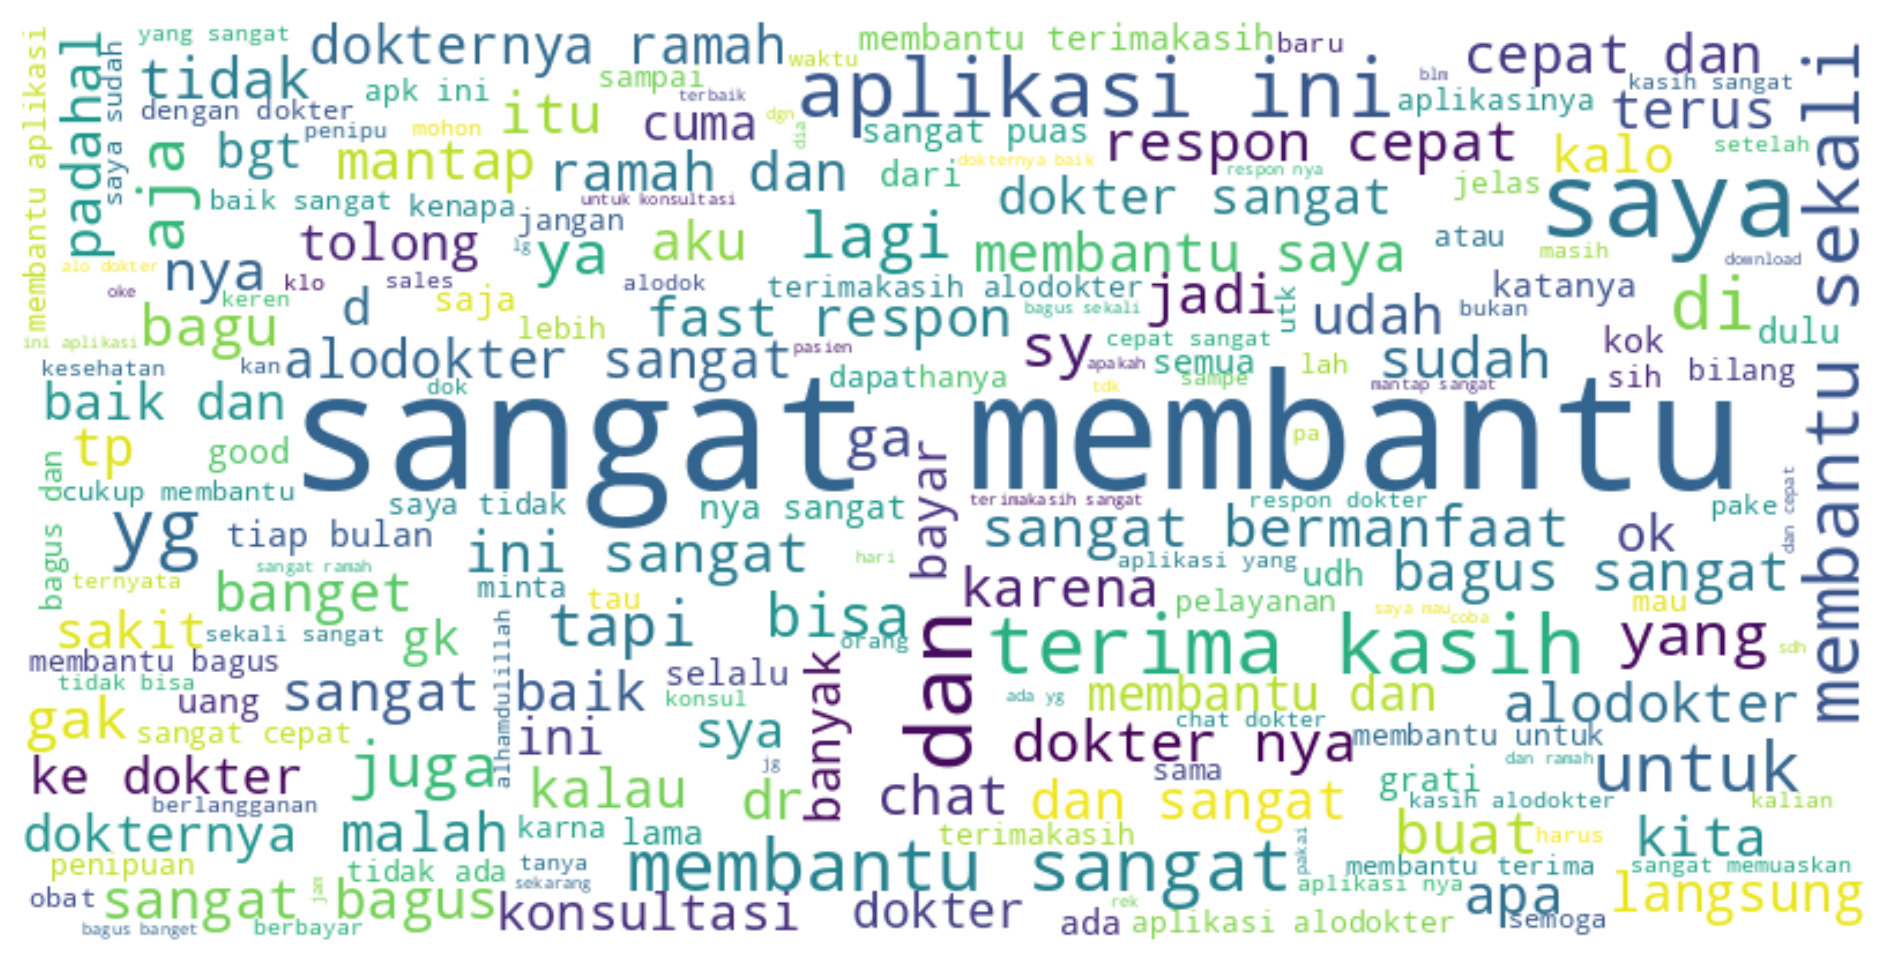

In [32]:
# Gabungkan semua kata dari kolom 'content' menjadi satu string
all_words_before = ' '.join(df_alodokter['content'])

# WordCloud sebelum menghapus stopwords
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(all_words_before)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_alodokter_before_stopwords.csv'
df_alodokter.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_before_stopwords.csv


## Menghapus tanda baca

In [34]:
# Membuat dataframe baru
df_alodokter_stopwords = df_alodokter.loc[:,["content", "score", "sentiment_polarity", "sentiment_subjective", "sentiment_rating", "wordCount"]]
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['content'].apply(
    lambda x: x.translate(str.maketrans("","",string.punctuation)))
df_alodokter_stopwords

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating,wordCount,review_without_stopwords
0,bagus cepat,5,0.0,0.0,Positive,2,bagus cepat
1,"dokternya ramah dan cepat dalm menjawab konsultasi pasien, namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampai"".sya berhar...",2,0.0,0.0,Negative,40,dokternya ramah dan cepat dalm menjawab konsultasi pasien namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampaisya berharap ...
2,penjelasan sangat detail dan dokternya ramah good joob,5,0.7,0.6,Positive,8,penjelasan sangat detail dan dokternya ramah good joob
3,ingin tahu tentang kedokteran,5,0.0,0.0,Positive,4,ingin tahu tentang kedokteran
4,sangat rinci,4,0.0,0.0,Positive,2,sangat rinci
...,...,...,...,...,...,...,...
24994,mantap,5,0.0,0.0,Positive,1,mantap
24995,"awalnya bagus karena dokter merespon obat apa yg harus ditebus, ketika sudah ditebus di aloshop, pengiriman obatnya ga datang datang padahal ambil pengiriman yg 3 jam sampai, pelayanan buruk !!! j...",1,0.0,0.0,Negative,56,awalnya bagus karena dokter merespon obat apa yg harus ditebus ketika sudah ditebus di aloshop pengiriman obatnya ga datang datang padahal ambil pengiriman yg 3 jam sampai pelayanan buruk jangan ...
24996,sangat membantu,5,0.0,0.0,Positive,2,sangat membantu
24997,mantul,5,0.0,0.0,Positive,1,mantul


# Menghapus Stopwords

In [35]:
import requests

# Unduh daftar stopwords dari URL
url = 'https://raw.githubusercontent.com/masdevid/ID-Stopwords/master/id.stopwords.02.01.2016.txt'
response = requests.get(url)

# Simpan daftar stopwords ke file lokal
with open('id_stopwords.txt', 'w') as file:
    file.write(response.text)

# Baca stopwords dari file
with open('id_stopwords.txt', 'r') as file:
    stopwords_id = file.read().splitlines()

# Menampilkan beberapa stopwords
print(f"Terdapat total {len(stopwords_id)} kata stopwords dalam bahasa Indonesia:")
print(stopwords_id[:10])  # Menampilkan 10 kata pertama dari daftar stopwords


Terdapat total 758 kata stopwords dalam bahasa Indonesia:
['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir']


In [36]:
# Fungsi untuk menghapus stopwords dari teks
def remove_stopwords(text, stopwords_list):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_list]
    return ' '.join(filtered_words)

In [37]:
# Menghapus stopwords dari kolom 'review_without_stopwords'
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

# Menampilkan hasil
df_alodokter_stopwords

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating,wordCount,review_without_stopwords
0,bagus cepat,5,0.0,0.0,Positive,2,bagus cepat
1,"dokternya ramah dan cepat dalm menjawab konsultasi pasien, namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampai"".sya berhar...",2,0.0,0.0,Negative,40,dokternya ramah cepat dalm konsultasi pasien utuk pemesanan resep obat via online lambat kecewa karna mnunggu obat yng d pesan gk sampaisya berharap kejadian sprti terulang
2,penjelasan sangat detail dan dokternya ramah good joob,5,0.7,0.6,Positive,8,penjelasan detail dokternya ramah good joob
3,ingin tahu tentang kedokteran,5,0.0,0.0,Positive,4,kedokteran
4,sangat rinci,4,0.0,0.0,Positive,2,rinci
...,...,...,...,...,...,...,...
24994,mantap,5,0.0,0.0,Positive,1,mantap
24995,"awalnya bagus karena dokter merespon obat apa yg harus ditebus, ketika sudah ditebus di aloshop, pengiriman obatnya ga datang datang padahal ambil pengiriman yg 3 jam sampai, pelayanan buruk !!! j...",1,0.0,0.0,Negative,56,bagus dokter merespon obat yg ditebus ditebus aloshop pengiriman obatnya ga ambil pengiriman yg 3 jam pelayanan buruk pesen deh kalo butuh obat urgent gatau skrg obat yg pesen dikirim kemana
24996,sangat membantu,5,0.0,0.0,Positive,2,membantu
24997,mantul,5,0.0,0.0,Positive,1,mantul


In [40]:
# Fungsi untuk menghitung kata yang sering muncul
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})

    # Memilih kata yang paling sering muncul
    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(20, 5))
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel='Count')
    plt.show()

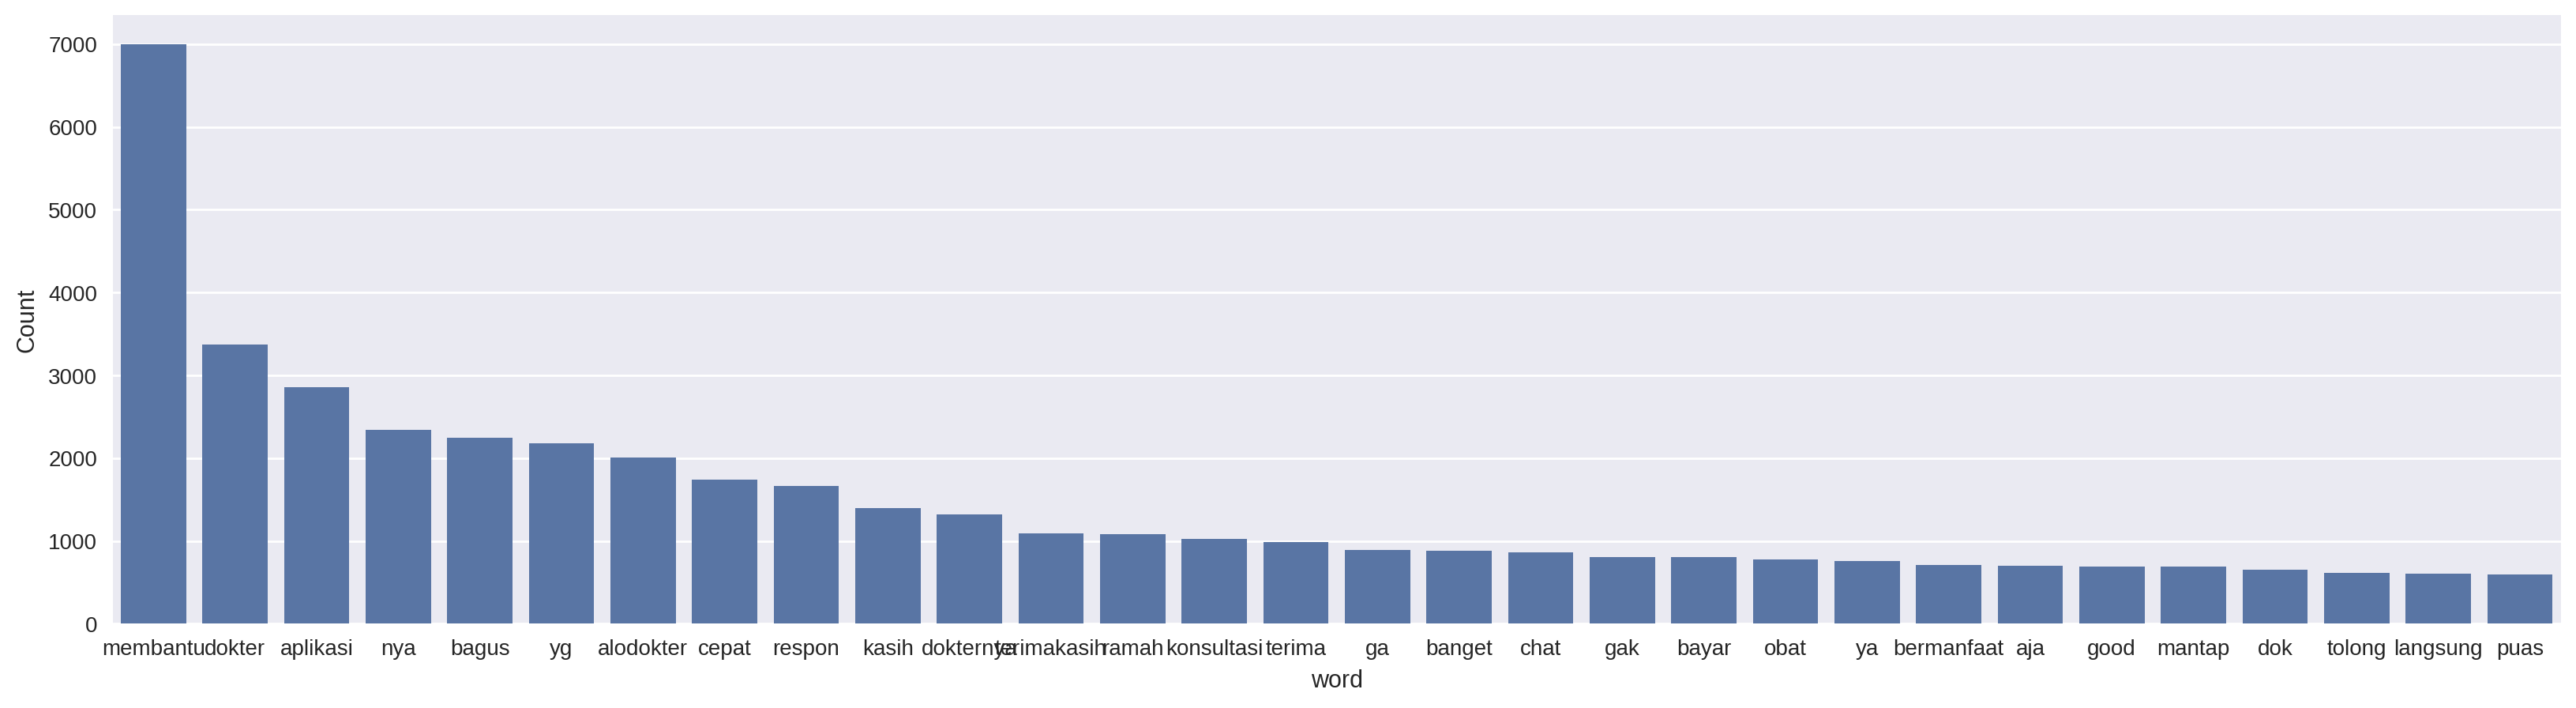

In [41]:
freq_words(df_alodokter_stopwords['review_without_stopwords'], terms=30)

In [42]:
stopwords_id = stopwords_id + ["nya", "yg", "ya", "aja"]

In [43]:
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

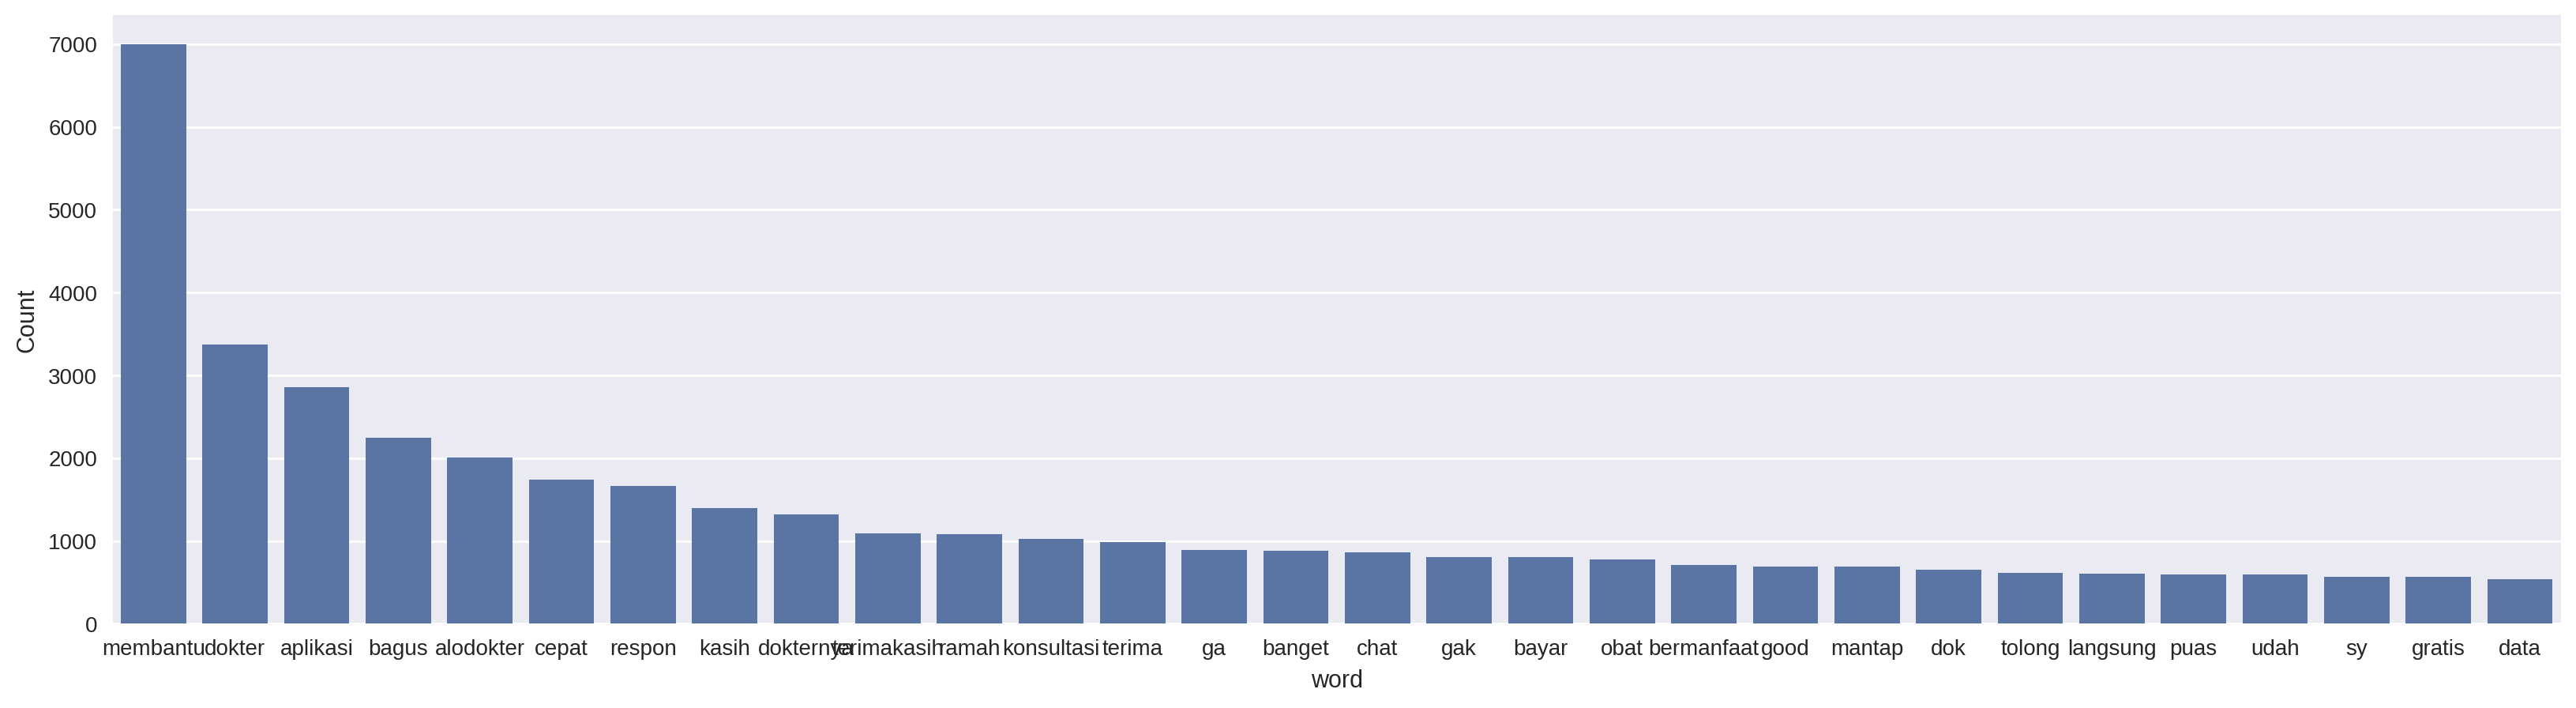

In [44]:
freq_words(df_alodokter_stopwords['review_without_stopwords'], terms=30)

In [49]:
stopwords_id = stopwords_id + ["sy","dg"]
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

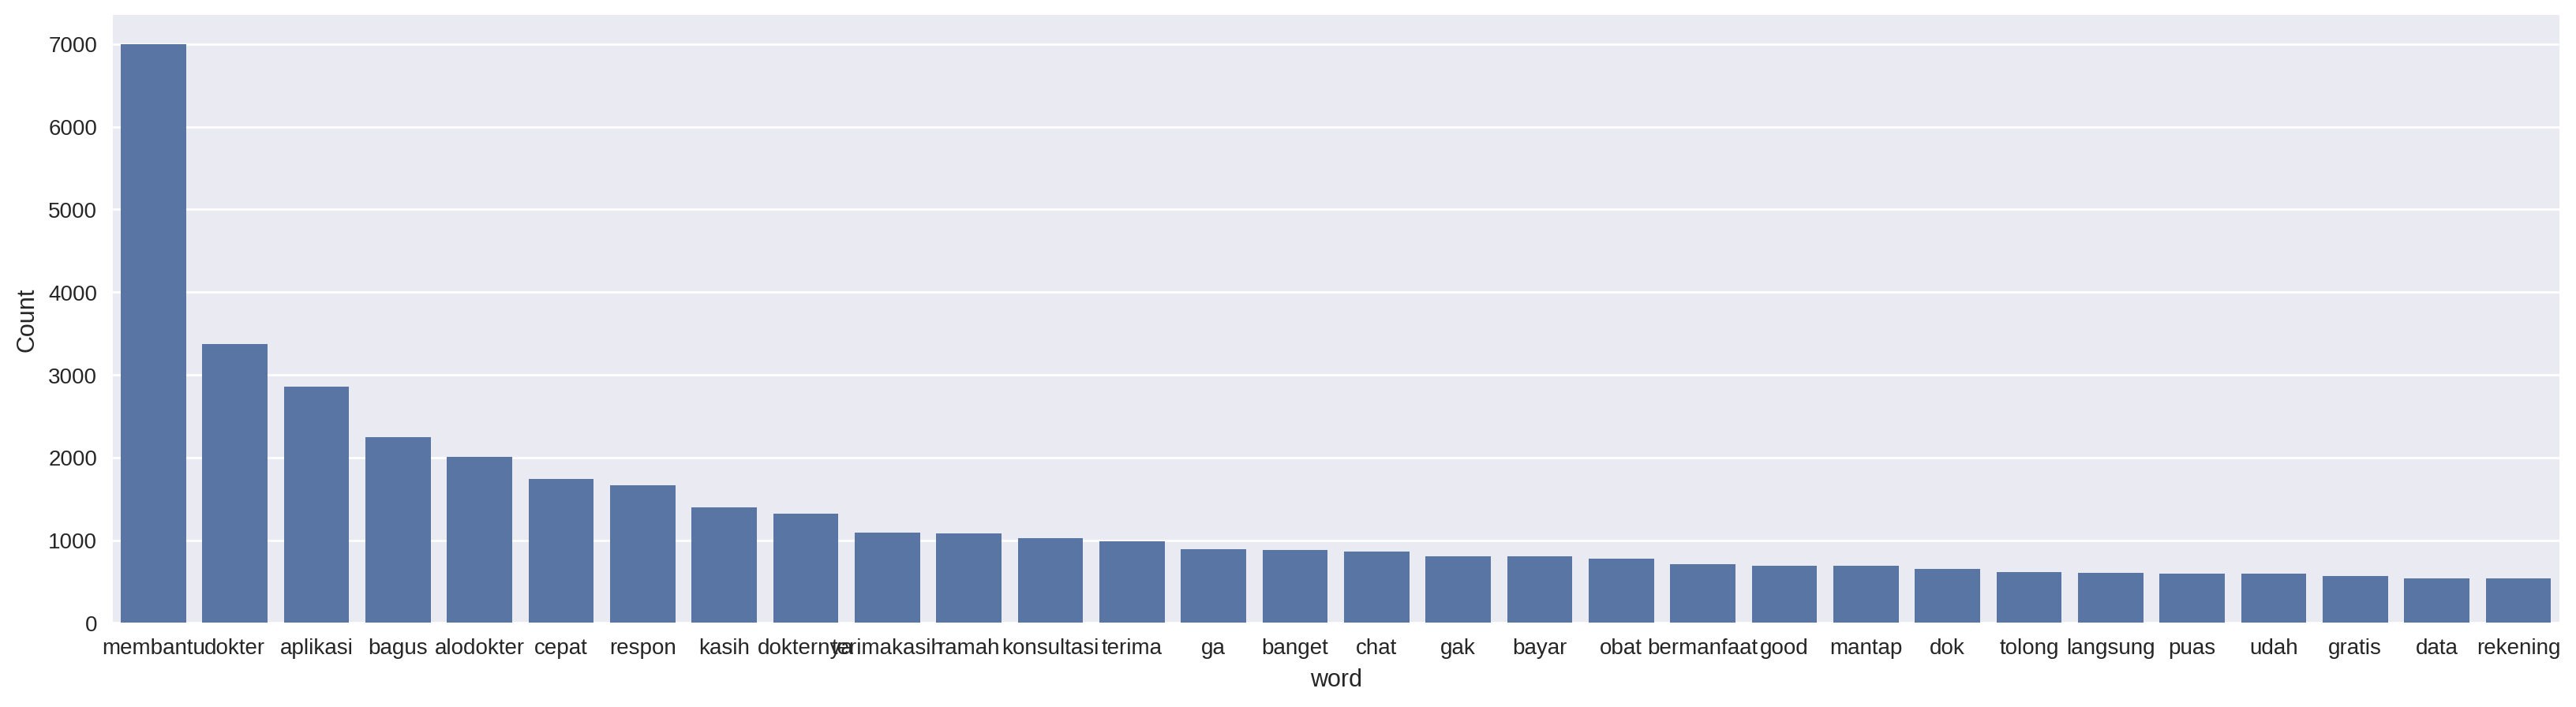

In [46]:
freq_words(df_alodokter_stopwords['review_without_stopwords'], terms=30)

# Text Analysis (Setelah Stopwords)

In [50]:
# Menghitung jumlah kata setelah menghapus stopwords
df_alodokter_stopwords['wordCount_after_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: len(x.split())
)

In [51]:
df_alodokter_stopwords.loc[:,["content","score","sentiment_polarity", "sentiment_rating","wordCount","review_without_stopwords", "wordCount_after_stopwords"]]

,content,score,sentiment_polarity,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords
0,bagus cepat,5,0.0,Positive,2,bagus cepat,2
1,"dokternya ramah dan cepat dalm menjawab konsultasi pasien, namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampai"".sya berhar...",2,0.0,Negative,40,dokternya ramah cepat dalm konsultasi pasien utuk pemesanan resep obat via online lambat kecewa karna mnunggu obat yng d pesan gk sampaisya berharap kejadian sprti terulang,26
2,penjelasan sangat detail dan dokternya ramah good joob,5,0.7,Positive,8,penjelasan detail dokternya ramah good joob,6
3,ingin tahu tentang kedokteran,5,0.0,Positive,4,kedokteran,1
4,sangat rinci,4,0.0,Positive,2,rinci,1
...,...,...,...,...,...,...,...
24994,mantap,5,0.0,Positive,1,mantap,1
24995,"awalnya bagus karena dokter merespon obat apa yg harus ditebus, ketika sudah ditebus di aloshop, pengiriman obatnya ga datang datang padahal ambil pengiriman yg 3 jam sampai, pelayanan buruk !!! j...",1,0.0,Negative,56,bagus dokter merespon obat ditebus ditebus aloshop pengiriman obatnya ga ambil pengiriman 3 jam pelayanan buruk pesen deh kalo butuh obat urgent gatau skrg obat pesen dikirim kemana,28
24996,sangat membantu,5,0.0,Positive,2,membantu,1
24997,mantul,5,0.0,Positive,1,mantul,1


In [52]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_alodokter_after_stopwords.csv'
df_alodokter_stopwords.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_after_stopwords.csv


# Stemming

Stemming berguna untuk memotong akhir kata/imbuhan, sehingga kata kembali menjadi bentuk dasarnya.

In [58]:
# Mengunduh library untuk stemming Bahasa Indonesia
!pip install PySastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 3.7 MB/s eta 0:00:00


In [59]:
# Import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [60]:
# Fungsi untuk stemming
def stemming_indonesia(text):
    if text is not None:
        # Lakukan stemming dan kembalikan hasilnya
        return stemmer.stem(text)
    return ''

In [61]:
# Terapkan stemming pada kolom 'review_without_stopwords'
df_alodokter_stopwords['review_stem_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(lambda x: stemming_indonesia(x))
# Menampilkan hasil untuk beberapa baris
df_alodokter_stopwords.loc[0:3, ['review_without_stopwords', 'review_stem_without_stopwords']]

,review_without_stopwords,review_stem_without_stopwords
0,bagus cepat,bagus cepat
1,dokternya ramah cepat dalm konsultasi pasien utuk pemesanan resep obat via online lambat kecewa karna mnunggu obat yng d pesan gk sampaisya berharap kejadian sprti terulang,dokter ramah cepat dalm konsultasi pasien utuk mesan resep obat via online lambat kecewa karna mnunggu obat yng d pesan gk sampaisya harap jadi sprti ulang
2,penjelasan detail dokternya ramah good joob,jelas detail dokter ramah good joob
3,kedokteran,dokter


In [62]:
# Menghapus semua baris yang memiliki nilai None di seluruh DataFrame
df_alodokter_stopwords = df_alodokter_stopwords.dropna()

In [63]:
df_alodokter_stopwords

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords,review_stem_without_stopwords
0,bagus cepat,5,0.0,0.0,Positive,2,bagus cepat,2,bagus cepat
1,"dokternya ramah dan cepat dalm menjawab konsultasi pasien, namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampai"".sya berhar...",2,0.0,0.0,Negative,40,dokternya ramah cepat dalm konsultasi pasien utuk pemesanan resep obat via online lambat kecewa karna mnunggu obat yng d pesan gk sampaisya berharap kejadian sprti terulang,26,dokter ramah cepat dalm konsultasi pasien utuk mesan resep obat via online lambat kecewa karna mnunggu obat yng d pesan gk sampaisya harap jadi sprti ulang
2,penjelasan sangat detail dan dokternya ramah good joob,5,0.7,0.6,Positive,8,penjelasan detail dokternya ramah good joob,6,jelas detail dokter ramah good joob
3,ingin tahu tentang kedokteran,5,0.0,0.0,Positive,4,kedokteran,1,dokter
4,sangat rinci,4,0.0,0.0,Positive,2,rinci,1,rinci
...,...,...,...,...,...,...,...,...,...
24994,mantap,5,0.0,0.0,Positive,1,mantap,1,mantap
24995,"awalnya bagus karena dokter merespon obat apa yg harus ditebus, ketika sudah ditebus di aloshop, pengiriman obatnya ga datang datang padahal ambil pengiriman yg 3 jam sampai, pelayanan buruk !!! j...",1,0.0,0.0,Negative,56,bagus dokter merespon obat ditebus ditebus aloshop pengiriman obatnya ga ambil pengiriman 3 jam pelayanan buruk pesen deh kalo butuh obat urgent gatau skrg obat pesen dikirim kemana,28,bagus dokter merespon obat tebus tebus aloshop kirim obat ga ambil kirim 3 jam layan buruk sen deh kalo butuh obat urgent gatau skrg obat sen kirim mana
24996,sangat membantu,5,0.0,0.0,Positive,2,membantu,1,bantu
24997,mantul,5,0.0,0.0,Positive,1,mantul,1,mantul


In [64]:
# Hasil akhir
df_alodokter_stopwords.loc[:,["content","score","sentiment_rating","wordCount","review_without_stopwords", "wordCount_after_stopwords", 'review_stem_without_stopwords']]

,content,score,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords,review_stem_without_stopwords
0,bagus cepat,5,Positive,2,bagus cepat,2,bagus cepat
1,"dokternya ramah dan cepat dalm menjawab konsultasi pasien, namun utuk pemesanan resep obat via online lambat dan saya merasa kecewa karna mnunggu sangat lama obat yng d pesan gk sampai"".sya berhar...",2,Negative,40,dokternya ramah cepat dalm konsultasi pasien utuk pemesanan resep obat via online lambat kecewa karna mnunggu obat yng d pesan gk sampaisya berharap kejadian sprti terulang,26,dokter ramah cepat dalm konsultasi pasien utuk mesan resep obat via online lambat kecewa karna mnunggu obat yng d pesan gk sampaisya harap jadi sprti ulang
2,penjelasan sangat detail dan dokternya ramah good joob,5,Positive,8,penjelasan detail dokternya ramah good joob,6,jelas detail dokter ramah good joob
3,ingin tahu tentang kedokteran,5,Positive,4,kedokteran,1,dokter
4,sangat rinci,4,Positive,2,rinci,1,rinci
...,...,...,...,...,...,...,...
24994,mantap,5,Positive,1,mantap,1,mantap
24995,"awalnya bagus karena dokter merespon obat apa yg harus ditebus, ketika sudah ditebus di aloshop, pengiriman obatnya ga datang datang padahal ambil pengiriman yg 3 jam sampai, pelayanan buruk !!! j...",1,Negative,56,bagus dokter merespon obat ditebus ditebus aloshop pengiriman obatnya ga ambil pengiriman 3 jam pelayanan buruk pesen deh kalo butuh obat urgent gatau skrg obat pesen dikirim kemana,28,bagus dokter merespon obat tebus tebus aloshop kirim obat ga ambil kirim 3 jam layan buruk sen deh kalo butuh obat urgent gatau skrg obat sen kirim mana
24996,sangat membantu,5,Positive,2,membantu,1,bantu
24997,mantul,5,Positive,1,mantul,1,mantul


In [65]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_alodokter_after_stopwords_stemming.csv'
df_alodokter_stopwords.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_after_stopwords_stemming.csv
